In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from collections import Counter

#import race data label lists
%store -r races
%store -r races2
%store -r real_order

In [3]:
#Accuracy metric from page 13 of https://arxiv.org/pdf/1912.03250.pdf
#INPUT:
# mu: parameter
# p_histogram: histogram (1D array of length n) of population sizes for the true data
# q_histogram: histogram (1D array of length n) of population sizes for the de-identified data
#--------------------------------------------------------------------------
#OUTPUT:
# div: a real number representing the mu-smoothed KL divergence between distributions P and Q
def Dkl(mu, p_histogram, q_histogram):
    div = 0
    for i in range(len(p_histogram)):
        s = (p_histogram[i] + mu)*np.log((p_histogram[i] + mu)/(q_histogram[i] + mu))
        div += s
    return div

In [4]:
#Returns mu-smoothed KL divergence between a given original dataset & a de-identified dataset 

#INPUT:
# county: string of the county from which to use original data
#file: swapping file to evaluate performance of 
#threshold: cut off for consideration as minority group 
#mu: parameter for Dkl
#--------------------------------------------------------------------------
#OUTPUT:
#Returns real-valued mu-smoothed KL divergence value 

def get_hists_swap(county, file, threshold):
    
    #ORIGINAL DATA
    
    #import original dataset & delete unnecessary rows
    df_orig = pd.read_csv (r'../homemade_data/'+county+'.csv')
    df_orig = df_orig.loc[:, ~df_orig.columns.str.contains('^Unnamed')]
    df_orig = df_orig.loc[:, ~df_orig.columns.str.contains('SwapVal')]
    #replace race w/ value 0-126; where 0-62 represent non-hispanic and 63-126 represent hispanic
    for index, row in df_orig.iterrows():
        d = row['race']
        h = row['hispanic']
        #if hispanic, increment to 63-126 range
        if d in races and h==1:
            df_orig.at[index, 'race'] = races.index(d)+len(races)
        #else, 0-63 range
        elif d in races and h==0:
            df_orig.at[index, 'race'] = races.index(d)
    
    
    #get list of occurrences by race using counter - original dataset
    #LABELS_ALL = race numbers 0-126
    #VALUES_ALL = associated counts for race numbers 0-126
    labels_all = []
    vals_all = []
    for key1, value1 in df_orig.iteritems():
        if(key1 == 'race'):
            labs, vals = zip(*Counter(value1).items())
            labs = list(labs)
            vals = list(vals)
            #for each race value, get number of occurences and append label and value of each
            for i in range(0, len(real_order)):
                if i not in labs:
                    labels_all.append(i)
                    vals_all.append(0)
                elif i in labs:
                    pos = labs.index(i)
                    labels_all.append(i)
                    vals_all.append(vals[pos])   
    labels_all = np.arange(0,len(real_order),1)
        
    
    #get associated race counts for hispanic and non-hispanic
    orig_nonhisp_vals = vals_all[0:len(races)]
    orig_hisp_vals = vals_all[len(races):]
    
    #create dataframe of his/non-his counts for each race; for ORIGINAL dataframe
    orig = pd.DataFrame({'Nonhispanic':orig_nonhisp_vals, 'Hispanic':orig_hisp_vals})
               
    
    #SWAPPING DATA
    
    #import original dataset & delete unnecessary rows
    df2 = pd.read_csv(file)
    #replace race w/ value 0-126; where 0-62 represent non-hispanic and 63-126 represent hispanic
    for index, row in df2.iterrows():
        d = row['race']
        h = row['hispanic']
        #if hispanic, increment to 63-126 range
        #0-62 represent non-hispanic and 63-126 represent hispanic
        if h==1:
            df2.at[index, 'race'] = d+len(races)
    

    #get list of occurrences by race using counter - de-identified swapping dataset
    #LABELS2_ALL = race numbers 0-126
    #VALUES2_ALL = associated counts for race numbers 0-126
    labels2_all = []
    vals2_all = []    
    for key, value in df2.iteritems():
        if(key == 'race'):
            labels2, values2 = zip(*Counter(value).items())
            labels2=list(labels2)
            values2 = list(values2)
            for i in range(0, len(real_order)):
                if i not in labels2:
                    labels2_all.append(i)
                    vals2_all.append(0)
                elif i in labels2:
                    pos = labels2.index(i)
                    labels2_all.append(i)
                    vals2_all.append(values2[pos])
    labels2_all = np.arange(0,len(real_order),1)
    
    #get associated race counts for hispanic and non-hispanic
    new_nonhisp_vals = vals2_all[0:len(races)]
    new_hisp_vals = vals2_all[len(races):]
    
    #create dataframe of his/non-his counts for each race; for ORIGINAL dataframe
    new = pd.DataFrame({'Nonhispanic':new_nonhisp_vals, 'Hispanic':new_hisp_vals})
    

    
    #iterate over columns to find total population
    total = 0
    for index, row in orig.iterrows():
        total = total + row['Hispanic']+row['Nonhispanic']

    
    q_histogram = [0 for i in range(len(real_order))]
    p_histogram = [0 for i in range(len(real_order))]
    
    #compute q_histogram and p_histogram, including all groups with population fraction <= threshold in original dataset
    #q_histogram contains population sizes of those groups in new dataset
    #p_histogram contains population sizes of those groups in old dataset
    #all entries corresponding to groups with population fraction > threshold are 0
    for index, val in enumerate(vals_all):
        if val/total <= threshold and index < len(races):
            q_histogram[index] = new.at[index, 'Nonhispanic']
            p_histogram[index] = val
        if val/total <= threshold and index >= len(races):
            q_histogram[index] = new.at[index-len(races), 'Hispanic']
            p_histogram[index] = val
    q_histogram = np.array(q_histogram)
    p_histogram = np.array(p_histogram)
            
    # remove negative values from q_histogram
    q_histogram = np.maximum(q_histogram, np.zeros(len(real_order)))
    return p_histogram, q_histogram

  

In [5]:
#INPUT:
# county: string specifying the county of interest
# file: string specifying the file for the de-identified data
# threshold: float defining the maximum population fraction of minority categories
#----------------------------------------------------------
#OUTPUT:
# p_histogram: 1D numpy array with length 126. contains population sizes in orig data of minority categories
# q_histogram: 1D numpy array with length 126. contains populations sizes in de-identified data of minority categories
def get_hists_dp(county, file, threshold):
    df_orig = pd.read_csv (r'../homemade_data/'+county+'.csv')
    df_orig = df_orig.loc[:, ~df_orig.columns.str.contains('^Unnamed')]
    df_orig = df_orig.loc[:, ~df_orig.columns.str.contains('SwapVal')]
    for index, row in df_orig.iterrows():
        d = row['race']
        h = row['hispanic']
        if d in races and h==1:
            df_orig.at[index, 'race'] = races.index(d)+len(races)
        elif d in races and h==0:
            df_orig.at[index, 'race'] = races.index(d)
    labels_all = []
    vals_all = []

    #get list of occurrences by race - orig
    for key1, value1 in df_orig.iteritems():
        if(key1 == 'race'):
            labs, vals = zip(*Counter(value1).items())
            labs = list(labs)
            vals = list(vals)
            for i in range(0, len(real_order)):
                if i not in labs:
                    labels_all.append(i)
                    vals_all.append(0)
                elif i in labs:
                    pos = labs.index(i)
                    labels_all.append(i)
                    vals_all.append(vals[pos])   
    labels_all = np.arange(0,len(real_order),1)
    
    orig_nonhisp_vals = vals_all[0:len(races)]
    orig_hisp_vals = vals_all[len(races):]

    q_histogram = [0 for i in range(len(real_order))]
    p_histogram = [0 for i in range(len(real_order))]
    
    
    
    df2 = pd.read_csv(file)      #dataframe corresponding to new dataset, with 63 rows (for each race) and 2 cols (for H/NH)
    orig = pd.DataFrame({'Nonhispanic':orig_nonhisp_vals, 'Hispanic':orig_hisp_vals}) #same as df2, but for orig data

    

    #iterate over columns to find total population
    total = 0
    for index, row in orig.iterrows():
        total = total + row['Hispanic']+row['Nonhispanic']
        
    final = orig.copy()
    for col in final.columns:
        final[col].values[:] = 0
        
    orig_nonhisp_vals.extend(orig_hisp_vals)
        
        
    #compute q_histogram and p_histogram, including all groups with population fraction <= threshold in original dataset
    #q_histogram contains population sizes of those groups in new dataset
    #p_histogram contains population sizes of those groups in old dataset
    #all entries corresponding to groups with population fraction > threshold are 0
    for index, val in enumerate(vals_all):
        if val/total <= threshold and index < len(races):
            q_histogram[index] = df2.at[index, 'Nonhispanic']
            p_histogram[index] = val
        if val/total <= threshold and index >= len(races):
            q_histogram[index] = df2.at[index-len(races), 'Hispanic']
            p_histogram[index] = val
    q_histogram = np.array(q_histogram)
    p_histogram = np.array(p_histogram)
            
    # remove negative values from q_histogram
    q_histogram = np.maximum(q_histogram, np.zeros(len(real_order)))

    return p_histogram, q_histogram
    

In [6]:
# returns KL divergence between the orig data and new data, where threshold defines which groups are considered 
# minorities, and mu is the Dkl param
def get_dkl_dp(county, file, threshold, mu):
    
    # compute p_histogram and q_histogram
    p_histogram, q_histogram = get_hists_dp(county, file, threshold)

    return Dkl(mu, p_histogram/np.sum(p_histogram), q_histogram/np.sum(q_histogram))

In [7]:
# returns KL divergence between the orig data and new data, where threshold defines which groups are considered 
# minorities, and mu is the Dkl param
def get_dkl_swap(county, file, threshold, mu):
    
    # compute p_histogram and q_histogram
    p_histogram, q_histogram = get_hists_swap(county, file, threshold)

    return Dkl(mu, p_histogram/np.sum(p_histogram), q_histogram/np.sum(q_histogram))

In [8]:
def get_mse(A, B):
    mse = ((A - B)**2).mean(axis=0)
    return mse

In [9]:
# returns mse between the vector of minority race pops in the orig data and vector of minority race pops in the new data, 
# where threshold defines which groups are considered minorities
def get_mse_dp(county, file, threshold):
    p_histogram, q_histogram = get_hists_dp(county, file, threshold)
    return get_mse(p_histogram, q_histogram)

In [10]:
# returns mse between the vector of minority race pops in the orig data and vector of minority race pops in the new data, 
# where threshold defines which groups are considered minorities
def get_mse_swap(county, file, threshold):
    p_histogram, q_histogram = get_hists_swap(county, file, threshold)
    return get_mse(p_histogram, q_histogram)

In [11]:
########################################################################################################################
#finds closest item in a list
#INPUT: list, target amount
#OUTPUT: value of closest item in list
# taken from https://stackoverflow.com/questions/8914491/finding-the-nearest-value-and-return-the-index-of-array-in-python
########################################################################################################################

def find_closest(A, target):
    #A must be sorted
    A=np.array(A)
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return A[idx]

In [12]:
def run_for_dp(directory, output_directory, threshold, mu):
    #run for epsilon values in ep
    ep = np.arange(.01, 10, .05, float)
    
    #round epsilons to 2 decimal points
    epsilon = []    
    for ee in ep:
        ee = str(round(ee,2))
        if ee[len(ee)-1] == '.':
            ee = str(e)+'0'
        epsilon.append(ee)

    dfinal = pd.DataFrame(columns=['filename', 'dkl'])
    
    #run for all files 
    for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                #just to track status
                if '_0.csv' in filename:
                    print(filename)
                #get dkl
                dkl = get_dkl_dp(county, directory+filename, threshold, mu)
                #save filename & data
                last = filename.rfind('_')
                filename = filename[:last]
                first = filename.rfind('_')
                filename = filename[first+1:]
                #find closest epsilon to filename 
                f = find_closest(ep, float(filename))
                dfinal = dfinal.append({'filename': f, 'dkl': dkl}, ignore_index=True)
    
    sorted = {}
    for e in epsilon:
        sorted[e] = []
        
    for column_name, data in dfinal.iterrows():
        for e in epsilon:
            if math.isclose(float(data[0]), float(e), abs_tol=0.00001):
                sorted[e].append(data[1])
                break

    for e in epsilon:
        if len(sorted[e])==0:
            sorted[e]=0
        else:
            sorted[e] = sum(sorted[e])/len(sorted[e])
                
    final = pd.DataFrame(columns=['filename', 'dkl'])
    for e in sorted:
        final = final.append({'filename': e, 'dkl': sorted[e]}, ignore_index=True)
                    
    csv_orig_data = final.to_csv(output_directory, index = True)
    
    

In [13]:
def run_for_swapping(directory, output_directory, threshold, mu):
    
    
    swaprate = np.arange(.01, 1, .05, float)
    
    swaprates = []
    
    for s in swaprate:
        swaprates.append(round(float(s),2))
    
    dfinal = pd.DataFrame(columns=['filename', 'dkl'])

    for filename in os.listdir(directory):
        
            if filename.endswith(".csv") : 
                if '_0.csv' in filename:
                    print(filename)
                
                dkl = get_dkl_swap(county, directory+filename, threshold, mu)
                #get mse
                #mse = get_mse_swap(county, directory+filename, threshold)                
                #save filename & data
                first = filename.find('_')
                last = filename.rfind('_')
                filename = filename[first+1:last]
                dfinal = dfinal.append({'filename': filename, 'dkl': dkl}, ignore_index=True)
     
    sorted = {}
    for s in swaprates:
        sorted[s] = []
    
    for column_name, data in dfinal.iterrows():       

        for s in swaprates:
            if round(float(data[0]),2) == s: 
                sorted[s].append(data[1])
                break
    
    for s in swaprates:
        sorted[s] = sum(sorted[s])/len(sorted[s])
                
    final = pd.DataFrame(columns=['filename', 'dkl'])
    for s in sorted:
        final = final.append({'filename': s, 'dkl': sorted[s]}, ignore_index=True)
                
    csv_orig_data = final.to_csv(output_directory, index = True)

In [14]:









################################################### RUNNING THE CODE #####################################################











In [291]:
counties = ['Alameda', 'Armstrong', 'Cibola', 'Fayette', 'GrandForks', 'Hawaii', 'Jefferson', 'Nantucket', 'Washington']
counties = ['Alameda']

mus = [.0001]

for county in counties:
    print(county)
    #directory = '../dp/new_dp_runs/'+county+'/2_age_race/'
    #directory = '../dp/new_dp_runs/'+county+'/15_age_race/'
    directory = '../dp/new_dp_runs/'+county+'/binary_age/'
    
    threshold = 1
    for mu in mus:
        print(mu)
        #output_directory = "mean_dif/"+county+"/dp/2_age_race_FINAL_DKL" + "mu" + str(mu) +".csv"
        #output_directory = "mean_dif/"+county+"/dp/15_age_race_FINAL_DKL" + "mu" + str(mu) +".csv"
        output_directory = "mean_dif/"+county+"/dp/binary_age_FINAL_DKL" + "mu" + str(mu) +".csv"
        run_for_dp(directory, output_directory, threshold, mu)

Alameda
0.0001
dprun_0.01_0.csv
dprun_0.06_0.csv
dprun_0.11_0.csv
dprun_0.16_0.csv
dprun_0.21_0.csv
dprun_0.26_0.csv
dprun_0.31_0.csv
dprun_0.36_0.csv
dprun_0.41_0.csv
dprun_0.46_0.csv
dprun_0.51_0.csv
dprun_0.56_0.csv
dprun_0.61_0.csv
dprun_0.66_0.csv
dprun_0.71_0.csv
dprun_0.76_0.csv
dprun_0.81_0.csv
dprun_0.86_0.csv
dprun_0.91_0.csv
dprun_0.96_0.csv
dprun_1.01_0.csv
dprun_1.06_0.csv
dprun_1.11_0.csv
dprun_1.16_0.csv
dprun_1.21_0.csv
dprun_1.26_0.csv
dprun_1.31_0.csv
dprun_1.36_0.csv
dprun_1.41_0.csv
dprun_1.46_0.csv
dprun_1.51_0.csv
dprun_1.56_0.csv
dprun_1.61_0.csv
dprun_1.66_0.csv
dprun_1.71_0.csv
dprun_1.76_0.csv
dprun_1.81_0.csv
dprun_1.86_0.csv
dprun_1.91_0.csv
dprun_1.96_0.csv
dprun_2.01_0.csv
dprun_2.06_0.csv
dprun_2.11_0.csv
dprun_2.15_0.csv
dprun_2.21_0.csv
dprun_2.26_0.csv
dprun_2.31_0.csv
dprun_2.36_0.csv
dprun_2.41_0.csv
dprun_2.46_0.csv
dprun_2.51_0.csv
dprun_2.56_0.csv
dprun_2.61_0.csv
dprun_2.66_0.csv
dprun_2.71_0.csv
dprun_2.76_0.csv
dprun_2.81_0.csv
dprun_2.86_0.csv

In [14]:
counties = ['Armstrong', 'Cibola', 'Fayette', 'GrandForks', 'Hawaii', 'Jefferson', 'Nantucket', 'Washington']
counties = ['Alameda']
for county in counties:
    print(county)
    directory = '../swapping/swap_runs2/'+county+'/similar/'
    output_directory =  "mean_dif/"+county+"/similar/FULL_FINAL_DKL.csv"
    threshold = 1
    mu = .0001
    run_for_swapping(directory, output_directory, threshold, mu)

Alameda
swap_0.01_0.csv
swap_0.02_0.csv
swap_0.03_0.csv
swap_0.04_0.csv
swap_0.05_0.csv
swap_0.060000000000000005_0.csv
swap_0.06999999999999999_0.csv
swap_0.08_0.csv
swap_0.09999999999999999_0.csv
swap_0.09_0.csv
swap_0.11_0.csv
swap_0.12_0.csv
swap_0.13_0.csv
swap_0.14_0.csv
swap_0.15000000000000002_0.csv
swap_0.16_0.csv
swap_0.17_0.csv
swap_0.18000000000000002_0.csv
swap_0.19_0.csv
swap_0.21000000000000002_0.csv
swap_0.22_0.csv
swap_0.23_0.csv
swap_0.24000000000000002_0.csv
swap_0.25_0.csv
swap_0.26_0.csv
swap_0.27_0.csv
swap_0.28_0.csv
swap_0.29000000000000004_0.csv
swap_0.2_0.csv
swap_0.31_0.csv
swap_0.32_0.csv
swap_0.33_0.csv
swap_0.34_0.csv
swap_0.35000000000000003_0.csv
swap_0.36000000000000004_0.csv
swap_0.37_0.csv
swap_0.38_0.csv
swap_0.39_0.csv
swap_0.3_0.csv
swap_0.41000000000000003_0.csv
swap_0.42000000000000004_0.csv
swap_0.43_0.csv
swap_0.44_0.csv
swap_0.45_0.csv
swap_0.46_0.csv
swap_0.47000000000000003_0.csv
swap_0.48000000000000004_0.csv
swap_0.49_0.csv
swap_0.4_0.csv


In [15]:
counties = ['Armstrong', 'Cibola', 'Fayette', 'GrandForks', 'Hawaii', 'Jefferson', 'Nantucket', 'Washington']
counties = ['Alameda']
for county in counties:
    print(county)
    directory = '../swapping/swap_runs/'+county+'/random/'
    output_directory =  "mean_dif/"+county+"/random/FAKE_FINAL_DKL.csv"
    threshold = 1
    mu = .0001
    run_for_swapping(directory, output_directory, threshold, mu)

Alameda
swap_0.01_0.csv
swap_0.02_0.csv
swap_0.03_0.csv
swap_0.04_0.csv
swap_0.05_0.csv
swap_0.060000000000000005_0.csv
swap_0.06999999999999999_0.csv
swap_0.08_0.csv
swap_0.09999999999999999_0.csv
swap_0.09_0.csv
swap_0.11_0.csv
swap_0.12_0.csv
swap_0.13_0.csv
swap_0.14_0.csv
swap_0.15000000000000002_0.csv
swap_0.16_0.csv
swap_0.17_0.csv
swap_0.18000000000000002_0.csv
swap_0.19_0.csv
swap_0.21000000000000002_0.csv
swap_0.22_0.csv
swap_0.23_0.csv
swap_0.24000000000000002_0.csv
swap_0.25_0.csv
swap_0.26_0.csv
swap_0.27_0.csv
swap_0.28_0.csv
swap_0.29000000000000004_0.csv
swap_0.2_0.csv
swap_0.31_0.csv
swap_0.32_0.csv
swap_0.33_0.csv
swap_0.34_0.csv
swap_0.35000000000000003_0.csv
swap_0.36000000000000004_0.csv
swap_0.37_0.csv
swap_0.38_0.csv
swap_0.39_0.csv
swap_0.3_0.csv
swap_0.41000000000000003_0.csv
swap_0.42000000000000004_0.csv
swap_0.43_0.csv
swap_0.44_0.csv
swap_0.45_0.csv
swap_0.46_0.csv
swap_0.47000000000000003_0.csv
swap_0.48000000000000004_0.csv
swap_0.49_0.csv
swap_0.4_0.csv


## 


################################################### TESTING #####################################################




In [12]:
# #FOR TESTING: compute divergence for alameda county
# county = 'alameda'
# xs = np.arange(0, 10, .1)
# ys = []
# eps = ['0.51', '1.01', '2.01', '3.01', '4.01', '5.01', '6.01', '7.01', '8.01', '9.01']
# # for filename in os.listdir('../dp/newdp_runs/'+county):
# #     if filename.endswith(".csv") and '_0.csv' in filename:
# #         print(filename)
# #         div = get_dkl_dp(county, '../dp/newdp_runs/'+county+'/' +filename, 1, .1)
        
# #         print(div)
# #         ys.append(div)

# # eps = ['100', '200', '500', '1000']
# threshold = .1
# divs = []
# mses = []
# print('threshold: ' + str(threshold))
# for ep in eps:
#     div = get_dkl_dp(county, '../dp/newdp_runs2/'+county+'/dprun_' + ep + '_0.csv', threshold, .0001)
#     print('epsilon: ' + ep)
#     mse = get_mse_dp(county, '../dp/newdp_runs/'+county+'/dprun_' + ep + '_0.csv', threshold)
#     print('div: ' + str(div))
#     #print('mse: ' + str(mse))
    
#     divs.append(div)
#     mses.append(mse)

# print(divs)
    
    

threshold: 0.1
epsilon: 0.51
div: 0.3679956787237458
epsilon: 1.01
div: 0.29833620925310467
epsilon: 2.01
div: 0.08694800025863056
epsilon: 3.01
div: 0.029111901221849833
epsilon: 4.01
div: 0.01923521202405898
epsilon: 5.01
div: 0.0
epsilon: 6.01
div: 0.009189592092405458
epsilon: 7.01
div: 0.0
epsilon: 8.01
div: 0.0
epsilon: 9.01
div: 0.0
[0.3679956787237458, 0.29833620925310467, 0.08694800025863056, 0.029111901221849833, 0.01923521202405898, 0.0, 0.009189592092405458, 0.0, 0.0, 0.0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


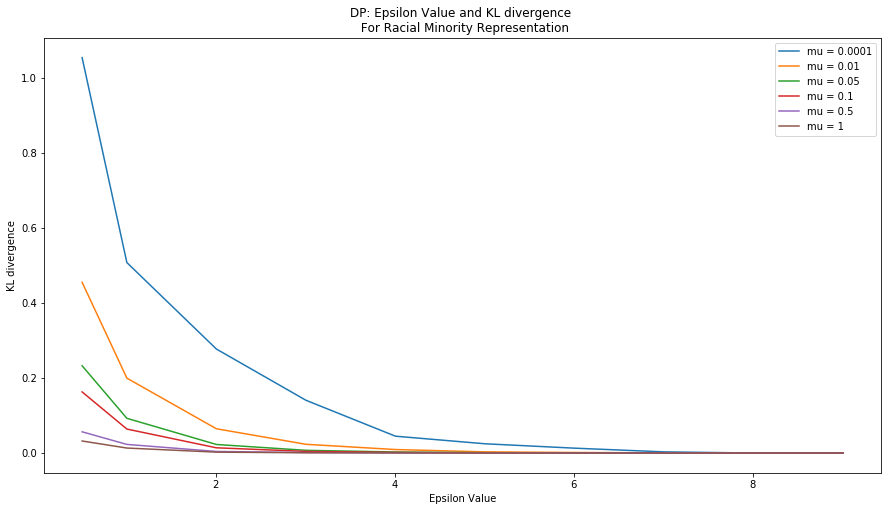

In [37]:
mus = [.0001, .01, .05, .1, .5, 1]
eps = ['0.51', '1.01', '2.01', '3.01', '4.01', '5.01', '6.01', '7.01', '8.01', '9.01']
xs = [.51, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01]
threshold = .1
plt.figure(figsize=(15,8))
for mu in mus:
    divs = []
    for ep in eps:
        div = get_dkl_dp(county, '../dp/dp_runs/'+county+'/dprun_' + ep + '_0.csv', threshold, mu)
        divs.append(div)
    plt.plot(xs, divs, label='mu = ' + str(mu))
axes= plt.axes()
plt.xlabel('Epsilon Value')
plt.ylabel('KL divergence')
plt.title('DP: Epsilon Value and KL divergence \n For Racial Minority Representation')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='upper right')
    
    

Alameda
['0.01', '0.11', '0.21000000000000002', '0.31000000000000005', '0.41000000000000003', '0.51', '0.6100000000000001', '0.7100000000000001', '0.81', '0.91']
[0.0007204008290345397, 0.031116483995015782, 0.10224775027581895, 0.17577957637685446, 0.1687185028983108, 0.19889042432660775, 0.21900634936246657, 0.2766365293531805, 0.28769517674735234, 0.37140012178414866]
['0.01', '0.11', '0.21000000000000002', '0.31000000000000005', '0.41000000000000003', '0.51', '0.6100000000000001', '0.7100000000000001', '0.81', '0.91']
[0.00019765105897819914, 0.005544365519591355, 0.019026130959073486, 0.029746785367861857, 0.041009283975345846, 0.062320024981712206, 0.08594273000055354, 0.11749347656784966, 0.13141381739563546, 0.19451495641351174]
['0.01', '0.11', '0.21000000000000002', '0.31000000000000005', '0.41000000000000003', '0.51', '0.6100000000000001', '0.7100000000000001', '0.81', '0.91']
[7.22874778766446e-05, 0.0020344196481640545, 0.007765193049583584, 0.012507354344838484, 0.0215861

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


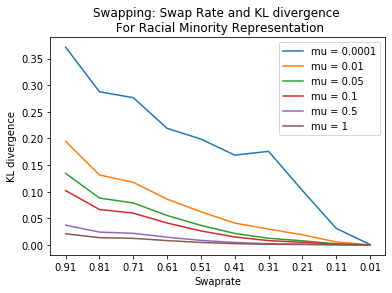

In [56]:
def run_for_swapping3(directory, output_directory, threshold, mus):
    
    
    for mu in mus:
        xs = []
        divs = []
        swaprates = ['_0.01', "_0.11", "_0.21", "_0.31", "_0.41", "_0.51", "_0.61", "_0.71", "_0.81", "_0.91"]

        dfinal = pd.DataFrame(columns=['filename', 'dkl'])

        for filename in os.listdir(directory):
            for swaprate in swaprates:
                if filename.endswith(".csv") and '_0.csv' in filename and swaprate in filename:
                    dkl = get_dkl_swap(county, directory+filename, threshold, mu)
                    first = filename.find('_')
                    last = filename.rfind('_')
                    filename = filename[first+1:last]
                    xs.append(filename)
                    divs.append(dkl)
        print(xs)
        print(divs)
        xs.reverse()
        divs.reverse()
        plt.plot(xs, divs, label='mu = ' + str(mu))

    axes= plt.axes()
    plt.xlabel('Swaprate')
    plt.ylabel('KL divergence')
    labels = xs.copy()
    for i, l in enumerate(labels):
        labels[i] = round(float(l),2)
        print(i,l)
#         if float(l) % .1 != 0:
#             labels[i] = ''
    plt.gca().set_xticklabels(labels)
    plt.title('Swapping: Swap Rate and KL divergence \n For Racial Minority Representation')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc='upper right')

 

    
counties = ['Armstrong', 'Cibola', 'Fayette', 'GrandForks', 'Hawaii', 'Jefferson', 'Nantucket', 'Washington']
counties = ['Alameda']
for county in counties:
    print(county)
#     directory = '../swapping/swap_runs2/'+county+'/similar/'
#     output_directory =  "mean_dif/"+county+"/similar/alameda_FINAL.csv"
    directory = '../swapping/swap_runs2/'+county+'/true_random/'
    output_directory = "mean_dif/"+county+"/random/TRUE_FINAL_DKL.csv"
    threshold = 1
    mus = [.0001, .01, .05, .1, .5, 1]
    run_for_swapping3(directory, output_directory, threshold, mus)
    
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


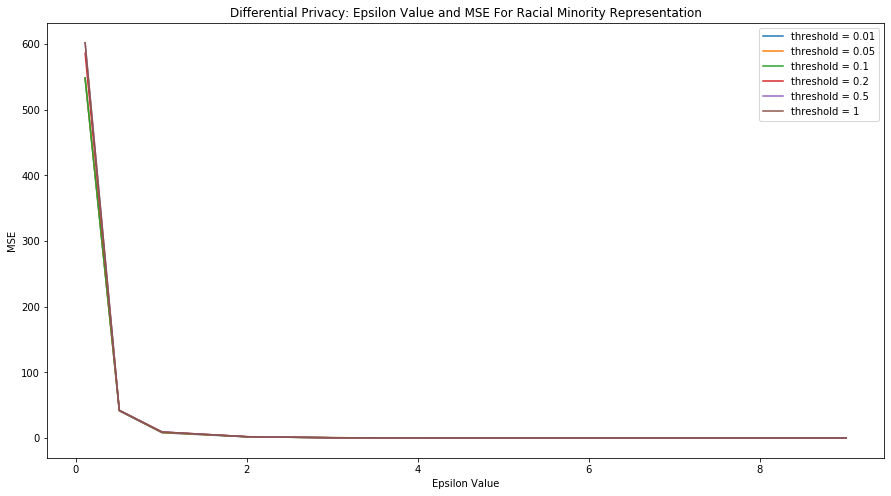

In [39]:
eps = ['0.11','0.51', '1.01', '2.01', '3.01', '4.01', '5.01', '6.01', '7.01', '8.01', '9.01']
#eps = ['0.11', '0.16', '0.21', '0.26', '0.31','0.36', '0.41', '0.46', '0.51', '0.56', '0.61']
xs = [ float(e) for e in eps]
#xs = [.01, .51, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01]
thresholds = [.01, .05, .1, .2, .5, 1]
plt.figure(figsize=(15,8))

for threshold in thresholds:
    mses = []
    for ep in eps:
        mse = get_mse_dp(county, '../dp/dp_runs/'+county+'/dprun_' + ep + '_0.csv', threshold)
        mses.append(mse)
    plt.plot(xs, mses, label='threshold = ' + str(threshold))
axes= plt.axes()
plt.xlabel('Epsilon Value')
plt.ylabel('MSE')
plt.title('Differential Privacy: Epsilon Value and MSE For Racial Minority Representation')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='upper right')

Alameda
0 0.91
1 0.81
2 0.71
3 0.61
4 0.51
5 0.41
6 0.31
7 0.21
8 0.11
9 0.01


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


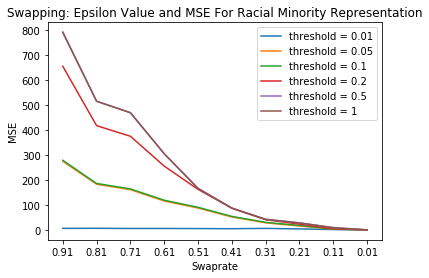

In [61]:
def run_for_swapping2(directory, thresholds, swaprates):
           
    
    for threshold in thresholds:
        mses = []
        xs = []
        for swaprate in swaprates: 
            for filename in os.listdir(directory): 
#                 print(swaprate)
#                 print(filename)
                if filename.endswith(".csv") and '_0.csv' in filename and swaprate in filename: 
                    mse = get_mse_swap(county, directory+filename, threshold)                
                    #save filename & data
                    first = filename.find('_')
                    last = filename.rfind('_')
                    filename = filename[first+1:last]
                    mses.append(mse)
                    xs.append(filename)
#         print(xs, mses)
        xs = [str(round(float(l), 2)) for l in xs]
        xs.reverse()
        mses.reverse()
        plt.plot(xs, mses, label='threshold = ' + str(threshold))
    
    axes= plt.axes()
    plt.xlabel('Swaprate')
    plt.ylabel('MSE')
    labels = xs.copy()
    for i, l in enumerate(labels):      
        labels[i] = str(round(float(l), 2))
        print(i,labels[i])
#         if float(l) % .1 != 0:
#             labels[i] = ''
    plt.title('Swapping: Epsilon Value and MSE For Racial Minority Representation')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc='upper right')


counties = ['Armstrong', 'Cibola', 'Fayette', 'GrandForks', 'Hawaii', 'Jefferson', 'Nantucket', 'Washington']
counties = ['Alameda']
for county in counties:
    print(county)
    directory = '../swapping/swap_runs2/'+county+'/similar/'
    thresholds = [.01, .05, .1, .2, .5, 1]
    #swaprates = ['_0.01', '_0.06', "_0.11", "_0.16", "_0.21"]
    swaprates = ['_0.01', "_0.11", "_0.21", "_0.31", "_0.41", "_0.51", "_0.61", "_0.71", "_0.81", "_0.91"]
    run_for_swapping2(directory, thresholds, swaprates)